Imports

In [1]:
# imports ..
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from statistics import mean, stdev
warnings.filterwarnings("ignore")

In [2]:
import time
# timeit wrapper to use in code
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"{func.__name__} took {elapsed_time:.2f} seconds to execute.")
        return result
    return wrapper

<h1>Pre-processing

<h2>Read the dataset

In [3]:
data_folder = './data/'
train_file = f'{data_folder}training_v2.csv'
unlabeled = pd.read_csv('./data/unlabeled.csv')

target = 'hospital_death'
unlabeled.drop(columns=target, inplace=True)

patients_df = pd.read_csv(train_file)

patients_df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


<h3>Explore the data

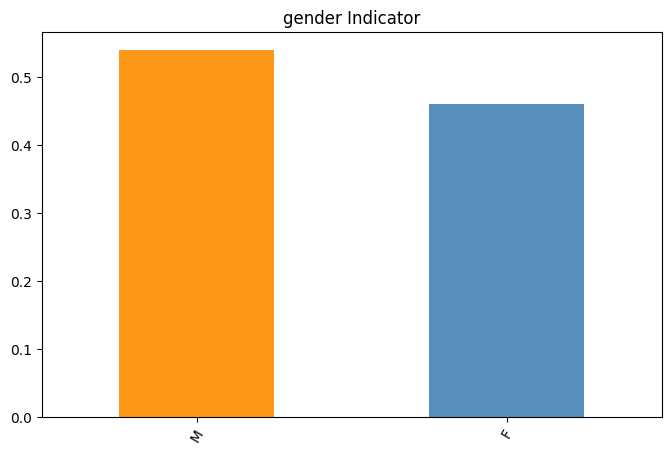

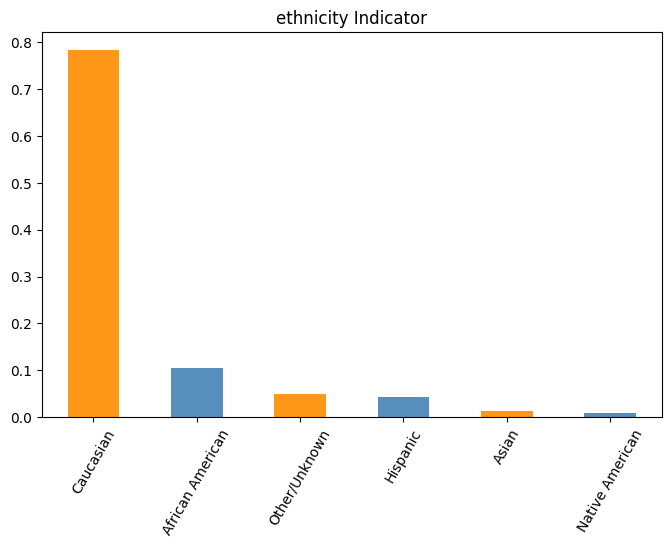

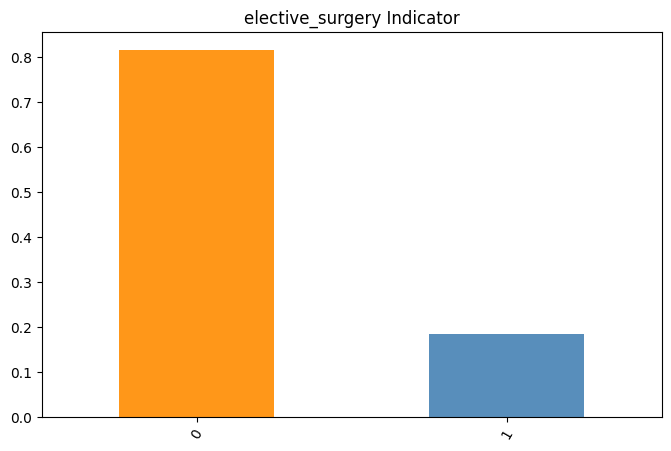

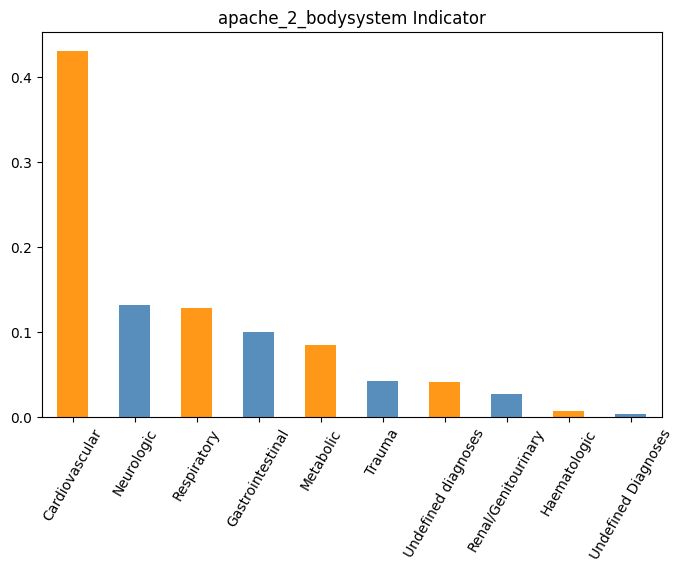

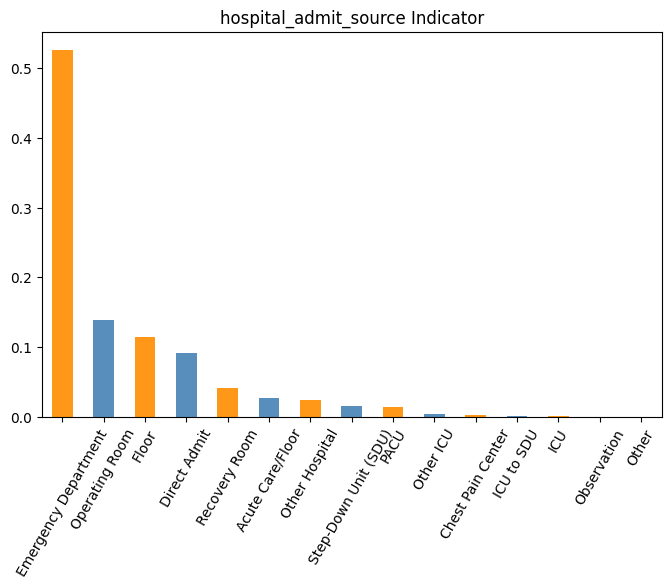

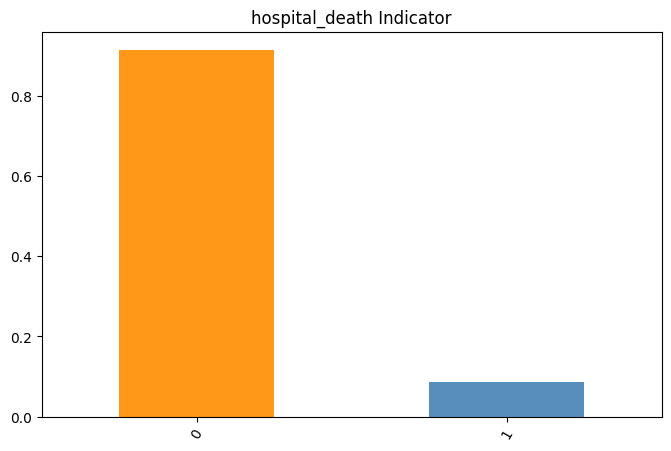

In [4]:
features_we_want_to_explore = ['gender', 'ethnicity', 'elective_surgery', 'apache_2_bodysystem', 'hospital_admit_source', target]
# explore feature
for feature in features_we_want_to_explore:
    fig = plt.figure(figsize = (8,5))
    patients_df[feature].value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=60)
    plt.title(f'{feature} Indicator')
    plt.show()

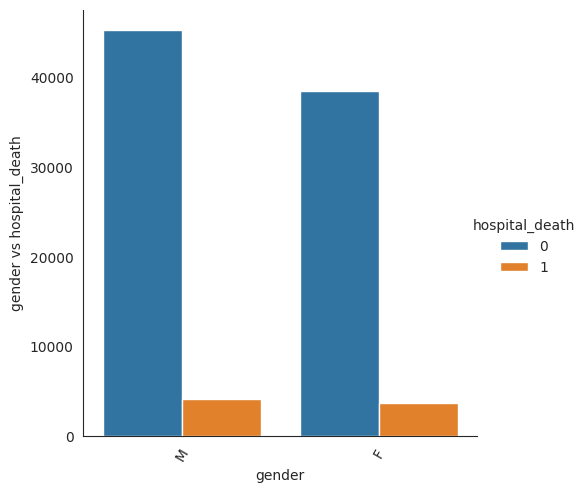

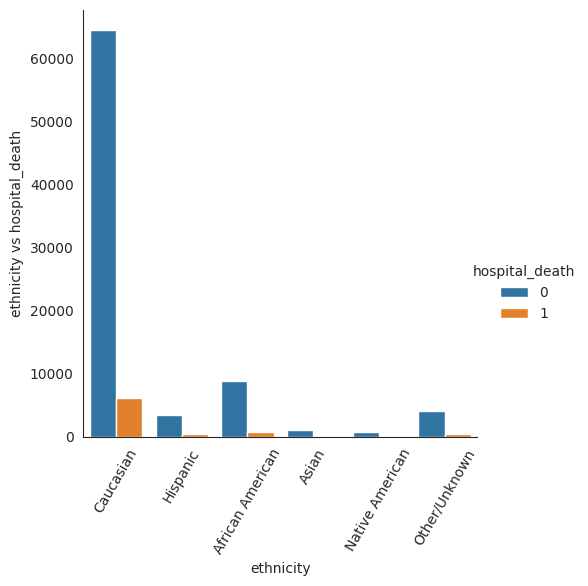

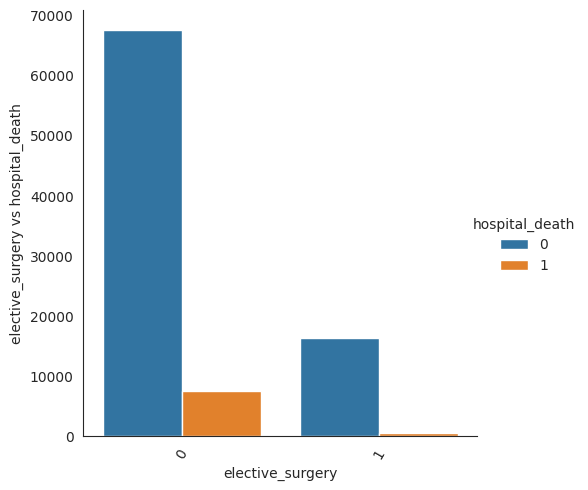

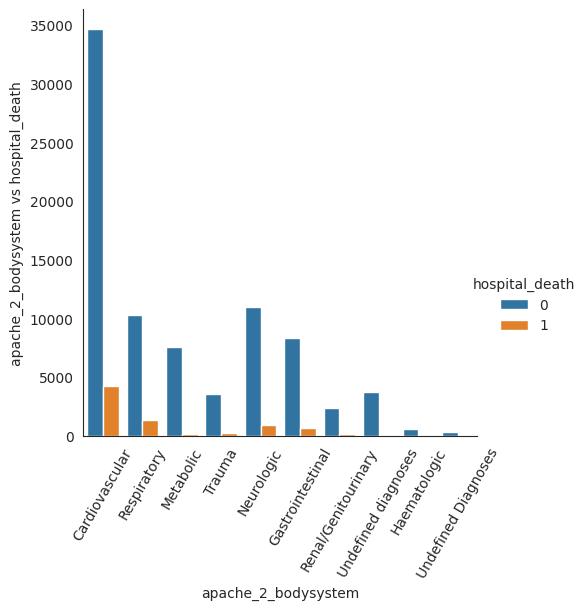

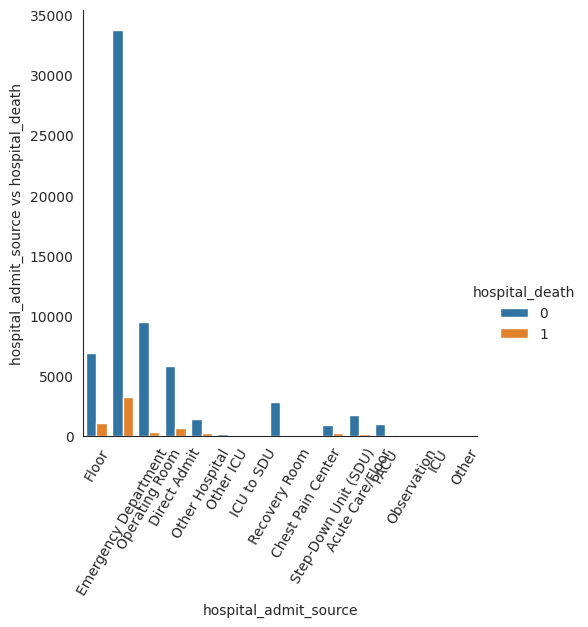

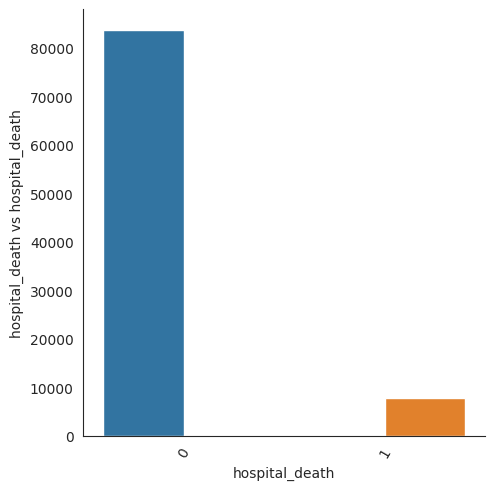

In [5]:
for feature in features_we_want_to_explore:
    with sns.axes_style('white'):
        g = sns.catplot(x=feature, data=patients_df, kind='count', hue=target)
        g.set_xticklabels(rotation=60)
        g.set_ylabels(f'{feature} vs {target}')

<h3>Handle missing data

In [6]:
# check how many nulls are present
total_na = patients_df.isna().sum().sum()
total_null = patients_df.isnull().sum().sum()
total_na + total_null

11486984

In [7]:
# remove nulls - for continues values use mean, for discrete use mode
for df in [patients_df, unlabeled]:
    for column in list(df.columns):
        value_to_insert = None
        if df[column].dtype == float:
            #print(f'float value found! at: {column}')
            value_to_insert = df[column].mean()        
        else:
            value_to_insert = df[column].mode()[0]
        #print(f'column: {column}, replacing value: {value_to_insert}')
        df[column].fillna(value_to_insert, inplace=True)

    total_na = df.isna().sum().sum()
    total_null = df.isnull().sum().sum()
    assert total_na == 0 and total_null == 0

<h3>Data label encoding

In [8]:
# get all columns where the values are strings
string_columns = patients_df.select_dtypes(include=[object])
string_columns_names = list(string_columns.columns)


# replace these columns with their enumerated value
for column_name in string_columns_names:    
    enumerated_unique_values = list(enumerate(string_columns[column_name].unique()))
    value_to_index_mapper = dict([(y,x) for x,y in enumerated_unique_values])
    patients_df[column_name].replace(value_to_index_mapper, inplace=True)
    if column_name != target:
        unlabeled[column_name].replace(value_to_index_mapper, inplace=True)

# make sure no string columns are left
assert len(patients_df.select_dtypes(include=[object]).columns) == 0
assert len(unlabeled.select_dtypes(include=[object]).columns) == 0

<h2>Feature extraction

In [9]:
# columns in use
hospital_id_column_name = 'hospital_id'
patient_count_column_name = 'hospital_visit_count'
hospital_death_col_name = 'hospital_death'
hospital_death_count_col_name = 'hospital_death_count'
percent_of_deaths_col_name = 'percent_of_deaths_in_hospital'

In [10]:
# add feature counting how many visits were at a hospital

patients_df[patient_count_column_name] = patients_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('size')
hospital_to_visit_df = patients_df[[hospital_id_column_name, patient_count_column_name]].drop_duplicates().to_dict()[hospital_id_column_name]
mean_of_visits = round(mean(hospital_to_visit_df.values()))
unlabeled[patient_count_column_name] = unlabeled[hospital_id_column_name].apply(lambda x: hospital_to_visit_df[x] if x in hospital_to_visit_df.keys() else mean_of_visits)

unlabeled[[hospital_id_column_name,patient_count_column_name]][unlabeled[patient_count_column_name] == mean_of_visits]


,hospital_id,hospital_visit_count
0,7,100
1,178,100
2,86,100
3,163,100
5,175,100
...,...,...
39303,163,100
39304,86,100
39305,152,100
39306,164,100


In [11]:
# count how many deaths were recorded for each hospital

patients_df[hospital_death_count_col_name] = patients_df.groupby(hospital_id_column_name)[hospital_id_column_name].transform('sum')
hospital_to_hospital_death_count = patients_df[[hospital_id_column_name, hospital_death_count_col_name]].drop_duplicates().to_dict()[hospital_id_column_name]
mean_of_death_count = round(mean(hospital_to_hospital_death_count.values()))
unlabeled[hospital_death_count_col_name] = unlabeled[hospital_id_column_name].apply(lambda x: hospital_to_hospital_death_count[x] if x in hospital_to_hospital_death_count.keys() else mean_of_death_count)

unlabeled[[hospital_id_column_name,hospital_death_count_col_name]]

,hospital_id,hospital_death_count
0,7,100
1,178,100
2,86,100
3,163,100
4,59,46
...,...,...
39303,163,100
39304,86,100
39305,152,100
39306,164,100


In [12]:
# get the percent of deaths among visits in a hospital

patients_df[percent_of_deaths_col_name] = patients_df.apply(lambda row: round(row[hospital_death_count_col_name] / row[patient_count_column_name], 4), axis=1)
patients_df[[percent_of_deaths_col_name]]

unlabeled[percent_of_deaths_col_name] = unlabeled.apply(lambda row: round(row[hospital_death_count_col_name] / row[patient_count_column_name], 4), axis=1)

unlabeled[percent_of_deaths_col_name][unlabeled[percent_of_deaths_col_name]==1]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
39303    1.0
39304    1.0
39305    1.0
39306    1.0
39307    1.0
Name: percent_of_deaths_in_hospital, Length: 39308, dtype: float64

In [13]:
# use clustering to extract another feature
# based on the float variables 
from sklearn.cluster import KMeans
import math

n_clusters = round(math.log(len(patients_df), 4))
float_columns = patients_df.select_dtypes(include=[float]).to_numpy()
float_columns_unlabeled = unlabeled.select_dtypes(include=[float]).to_numpy()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=3).fit(float_columns)
patients_df['clustering_value'] = kmeans.predict(float_columns)
unlabeled['clustering_value'] = kmeans.predict(float_columns_unlabeled)
unlabeled['clustering_value'].value_counts()

5    8864
1    8192
3    6642
0    5089
2    4208
7    3973
6    1834
4     506
Name: clustering_value, dtype: int64

<h3>Get rid of columns that contains ID

In [14]:
main_id_col_name = 'encounter_id'
main_id_col = unlabeled[[main_id_col_name]]
patients_df = patients_df[patients_df.columns.drop(list(patients_df.filter(regex='_id')))]
unlabeled = unlabeled[unlabeled.columns.drop(list(unlabeled.filter(regex='_id')))]


<h3>Quantile filtering anlysis

In [15]:
# lets see what happens if we remove the positive outliers by age
# (older people in the dataset)
quantile_by = 'age'
Q1 = patients_df[quantile_by].quantile(0.25)
Q3 = patients_df[quantile_by].quantile(0.75)
IQR = Q3 - Q1
threshold = 0.4 * IQR
print(f'max age in data: {patients_df[quantile_by].max()}')
print(f'IQR: {IQR}')
print(f'threshold: {threshold}')

max age in data: 89.0
IQR: 22.0
threshold: 8.8


In [16]:
# removal of outliers from dataset
print(f'before dropping shape: {patients_df.shape}')
dropped_rows = patients_df[((patients_df[quantile_by] > (Q3 + threshold)))]
left_rows = patients_df[~((patients_df[quantile_by] > (Q3 + threshold)))]
print(f'if we drop, the shape will be: {left_rows.shape}')
print(f'totally dropped {len(dropped_rows)} rows')
print(f'dropped ages {dropped_rows[quantile_by].unique()}')

before dropping shape: (91713, 186)
if we drop, the shape will be: (84242, 186)
totally dropped 7471 rows
dropped ages [87. 85. 88. 84. 86. 89.]


In [17]:
# what will be if we drop the age outliers ?
dropped_rows_dead = len(dropped_rows[dropped_rows[target] == 1])
dropped_rows_alive = len(dropped_rows[dropped_rows[target] == 0])
total_dead = len(patients_df[patients_df[target] == 1])
print(f'dropped patients which are dead: {len(dropped_rows[dropped_rows[target] == 1])}')
print(f'dropped patients which are alive: {len(dropped_rows[dropped_rows[target] == 0])}')
print(f'if we drop, we lose {round((dropped_rows_dead/total_dead) * 100,3)}% out of all records that are dead')

dropped patients which are dead: 1042
dropped patients which are alive: 6429
if we drop, we lose 13.165% out of all records that are dead


<h2>Feature selection

In [18]:
# simple feature selection based on minimum p-value similarity 
# with target value, based on ANOVA f-value

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

p_val_threshold = 0.01
select = SelectKBest(f_classif)
selected_df = select.fit_transform(patients_df, patients_df[target])
filter = select.get_support()
patients_df = patients_df[[name for i, name in enumerate(patients_df.columns) \
          if select.pvalues_[i] <= p_val_threshold]]
patients_df.columns

Index(['hospital_death', 'age', 'bmi', 'elective_surgery', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'pre_icu_los_days', 'weight',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=168)

In [19]:
# apply feature selection to unlabeled data
print(unlabeled.columns)
unlabeled = unlabeled[[x for x in patients_df.columns if x != target]]
unlabeled.columns

Index(['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'icu_type',
       ...
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'percent_of_deaths_in_hospital', 'clustering_value'],
      dtype='object', length=185)


Index(['age', 'bmi', 'elective_surgery', 'height', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'weight',
       'albumin_apache',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=167)

<h1>k-flod cross validation + binning

In [20]:
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

Binning hyper parameters

In [21]:
num_folds = 10

# find floats - features we want to bin
float_columns = patients_df.select_dtypes(include=[float])
features_to_bin = list(float_columns.columns)

evaluation_measures = {
    # name to (function, importance_weight)
    "accuracy": accuracy_score,
    "f1": f1_score,
    "precision": precision_score,
    "recall": recall_score,
    "auc": roc_auc_score
}

<h3>Methods used to perform the evaluation

perform_binning: 
    <ul>
    <li>performs the binning in-place,</li>
    <li>uses train decided bins on test data as well (to avoid data leakage)</li>
    <li>returns the bin_ranges dict for the binned features</li>


In [22]:
@timeit
def perform_binning(train_df, test_df, features_to_bin) -> dict:
    # Define the bin ranges and apply them for each feature needed
    # Do this based on the train set only 
    bin_ranges_dict = {}
    for feature in features_to_bin:
        if feature in train_df.columns:
            unique_values = np.unique(train_df[feature])
            num_bins = min(len(unique_values), 10)
            binning_func = pd.qcut if num_bins > 2 else pd.cut  # Use qcut for quantile-based binning or cut for equal-width binning
            _, bin_ranges = binning_func(train_df[feature], num_bins, retbins=True, labels=False, duplicates='drop')
            
            # begin at negative inf and finish at inf for first and last range
            # we cannot do bin_ranges[len(bin_ranges)-1] = np.inf,
            # because we might end up with 2 bins - ninf and inf
            bin_ranges = np.insert(bin_ranges, 0, np.NINF)            
            bin_ranges = np.append(bin_ranges, np.inf)

            bin_ranges_dict[feature] = bin_ranges

            train_df.sort_values(by=feature, inplace=True)
            test_df.sort_values(by=feature, inplace=True)
            
            train_df[f"{feature}_binned"] = pd.cut(train_df[feature], bins=bin_ranges_dict[feature], labels=False, include_lowest=True)
            train_df.drop(inplace=True, columns=feature)
            test_df[f"{feature}_binned"] = pd.cut(test_df[feature], bins=bin_ranges_dict[feature], labels=False, include_lowest=True)
            test_df.drop(inplace=True, columns=feature)
    return bin_ranges_dict

In [23]:
@timeit
def train(train_df, test_df, model) -> tuple:
    # Train and evaluate each model
    # Train the model on the train set
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]    
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]
        
    y_pred = model.predict(X_test)
    return (y_test, y_pred)

In [24]:
@timeit
def evaluate_inplace(model_name, fold, y_test, y_pred, results):
    # Calculate the accuracy of the model
    for measure_name, measure in evaluation_measures.items():
        if model_name not in results:
            results[model_name] = {}
        if measure_name not in results[model_name]:
            results[model_name][measure_name] = {}
        results[model_name][measure_name][fold] = measure(y_test, y_pred)

In [25]:
@timeit
def aggregate_results_across_folds(results_dict: dict) -> dict:
    aggregated_results = {}
    for model, measure_dict in results_dict.items():
        aggregated_results[model] = {}
        for measure, fold_values in measure_dict.items():
            aggregated_results[model][measure] = (mean(fold_values.values()), stdev(fold_values.values()))
    return aggregated_results

Binning is a rather heavy operation, so we decided to create the folds and the bin's separately,
Then use the list of folds (including the binning data along side the binned test and train)

In [56]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

folds = []
class Fold:
    def __init__(self, fold_index, train_df, test_df, bin_ranges) -> None:
        self.train_df = train_df
        self.test_df = test_df
        self.bin_ranges = bin_ranges
        self.fold_index = fold_index


After binning for the first time, the folds will be saved in data folder <br>
Next time they will be pulled from data folder instead of recalculated

In [57]:
# after binning for the first time, the folds will be saved in data folder
# next time they will be pulled from data folder instead of recalculated
path_to_folds_pickle = './data/folds.pickle'
if os.path.exists(path=path_to_folds_pickle):
    with open(path_to_folds_pickle, 'rb') as f:
        folds = pickle.load(f)
else:
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(patients_df)):    
        print(f"Starting binning for fold number Fold {fold_num}")    
        # Split into train and test sets
        train_df = patients_df.iloc[train_idx]
        test_df = patients_df.iloc[test_idx]
        # perform binning on the split 
        bin_ranges = perform_binning(train_df=train_df, test_df=test_df, features_to_bin=features_to_bin)          
        # add results to folds list
        folds.append(Fold(fold_index=fold_num, train_df=train_df, test_df=test_df, bin_ranges=bin_ranges))
        print(f'Binning is finished for fold number {fold_num}')    
        # any other post-split pre-processing should happen here
    with open(path_to_folds_pickle, 'wb') as f:
        pickle.dump(folds, f)

In [58]:
@timeit
def train_and_evaluate_models(models) -> dict:
    results_dict = {}
    for fold in folds:
        train_df = fold.train_df
        test_df = fold.test_df
        bin_ranges = fold.bin_ranges
        fold_num = fold.fold_index
        for model_name, model in models.items():        
            y_test, y_pred = train(train_df=train_df, test_df=test_df, model=model)
            evaluate_inplace(model_name=model_name, fold=fold_num, y_test=y_test, y_pred=y_pred, results=results_dict)
            print(f'Evaluation is finished for {model_name} in fold {fold_num}')
    aggregated_results = aggregate_results_across_folds(results_dict=results_dict)
    return aggregated_results

In [59]:
def plot_heatmap(aggregated_results):
    values = np.array([[aggregated_results[model_name][metric][0] for metric in evaluation_measures.keys()] for model_name in aggregated_results.keys()])

    # Create a heatmap
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(values, cmap='hot_r', interpolation='nearest',)

    # Set the x-axis tick labels to the metric names
    ax.set_xticks(np.arange(len(evaluation_measures.keys())))
    ax.set_xticklabels(evaluation_measures.keys())
    ax.tick_params(axis='x', which='major', labelsize=8, labelrotation=90)
    
    # Set the y-axis tick labels to the model names
    ax.set_yticks(np.arange(len(aggregated_results.keys())))
    ax.set_yticklabels(aggregated_results.keys())
    
    
    # Add a color scale
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Score', rotation=-90, va="bottom")

    # Show the values on each square
    for i in range(len(aggregated_results.keys())):
        for j in range(len(evaluation_measures.keys())):
            text_color = 'white' if im.norm(values[i, j]) > 0.5 else 'black'
            text = ax.text(j, i, f'{values[i, j]:.2f}', ha='center', va='center', color=text_color)

    ax

<h3> First let's give it a go with default hyper parameters

In [28]:
models = {
    "Random Forest Default HP": RandomForestClassifier(random_state=42),
    "Naive Bayes Default HP": GaussianNB(),
    "Logistic Regression Default HP": LogisticRegression(random_state=42),
    "K-NN Default HP": KNeighborsClassifier(),
    "Neural Network Default HP": MLPClassifier(random_state=42)
}

In [61]:
aggregated_results = train_and_evaluate_models(models=models)
aggregated_results

train took 30.68 seconds to execute.
evaluate_inplace took 0.01 seconds to execute.
Evaluation is finished for Random Forest Default HP in fold 0
train took 0.59 seconds to execute.
evaluate_inplace took 0.02 seconds to execute.
Evaluation is finished for Naive Bayes Default HP in fold 0
train took 3.51 seconds to execute.
evaluate_inplace took 0.02 seconds to execute.
Evaluation is finished for Logistic Regression Default HP in fold 0
train took 19.69 seconds to execute.
evaluate_inplace took 0.02 seconds to execute.
Evaluation is finished for K-NN Default HP in fold 0
train took 43.62 seconds to execute.
evaluate_inplace took 0.02 seconds to execute.
Evaluation is finished for Neural Network Default HP in fold 0
train took 29.58 seconds to execute.
evaluate_inplace took 0.01 seconds to execute.
Evaluation is finished for Random Forest Default HP in fold 1
train took 0.59 seconds to execute.
evaluate_inplace took 0.01 seconds to execute.
Evaluation is finished for Naive Bayes Default 

{'Random Forest Default HP': {'accuracy': (0.926902368351137,
   0.0032630942075040394),
  'f1': (0.3505515962742344, 0.031081914602455334),
  'precision': (0.7495184550691754, 0.03371180483033407),
  'recall': (0.22905585709687135, 0.02411851030014563),
  'auc': (0.6109293181965527, 0.012157315707774813)},
 'Naive Bayes Default HP': {'accuracy': (0.7989598878753886,
   0.004282836064663516),
  'f1': (0.36840524710346784, 0.01078759379617323),
  'precision': (0.25271088643696604, 0.008036309436739143),
  'recall': (0.679620796923019, 0.017618483946838785),
  'auc': (0.7449109712977084, 0.00851073867749366)},
 'Logistic Regression Default HP': {'accuracy': (0.9219085604840112,
   0.0030108039172654024),
  'f1': (0.3224752660000427, 0.030983359868721073),
  'precision': (0.6402207621024156, 0.026693223676031434),
  'recall': (0.21598096083582544, 0.02537717008307037),
  'auc': (0.602273257746759, 0.012357069319066197)},
 'K-NN Default HP': {'accuracy': (0.9140143602416138, 0.003086630434

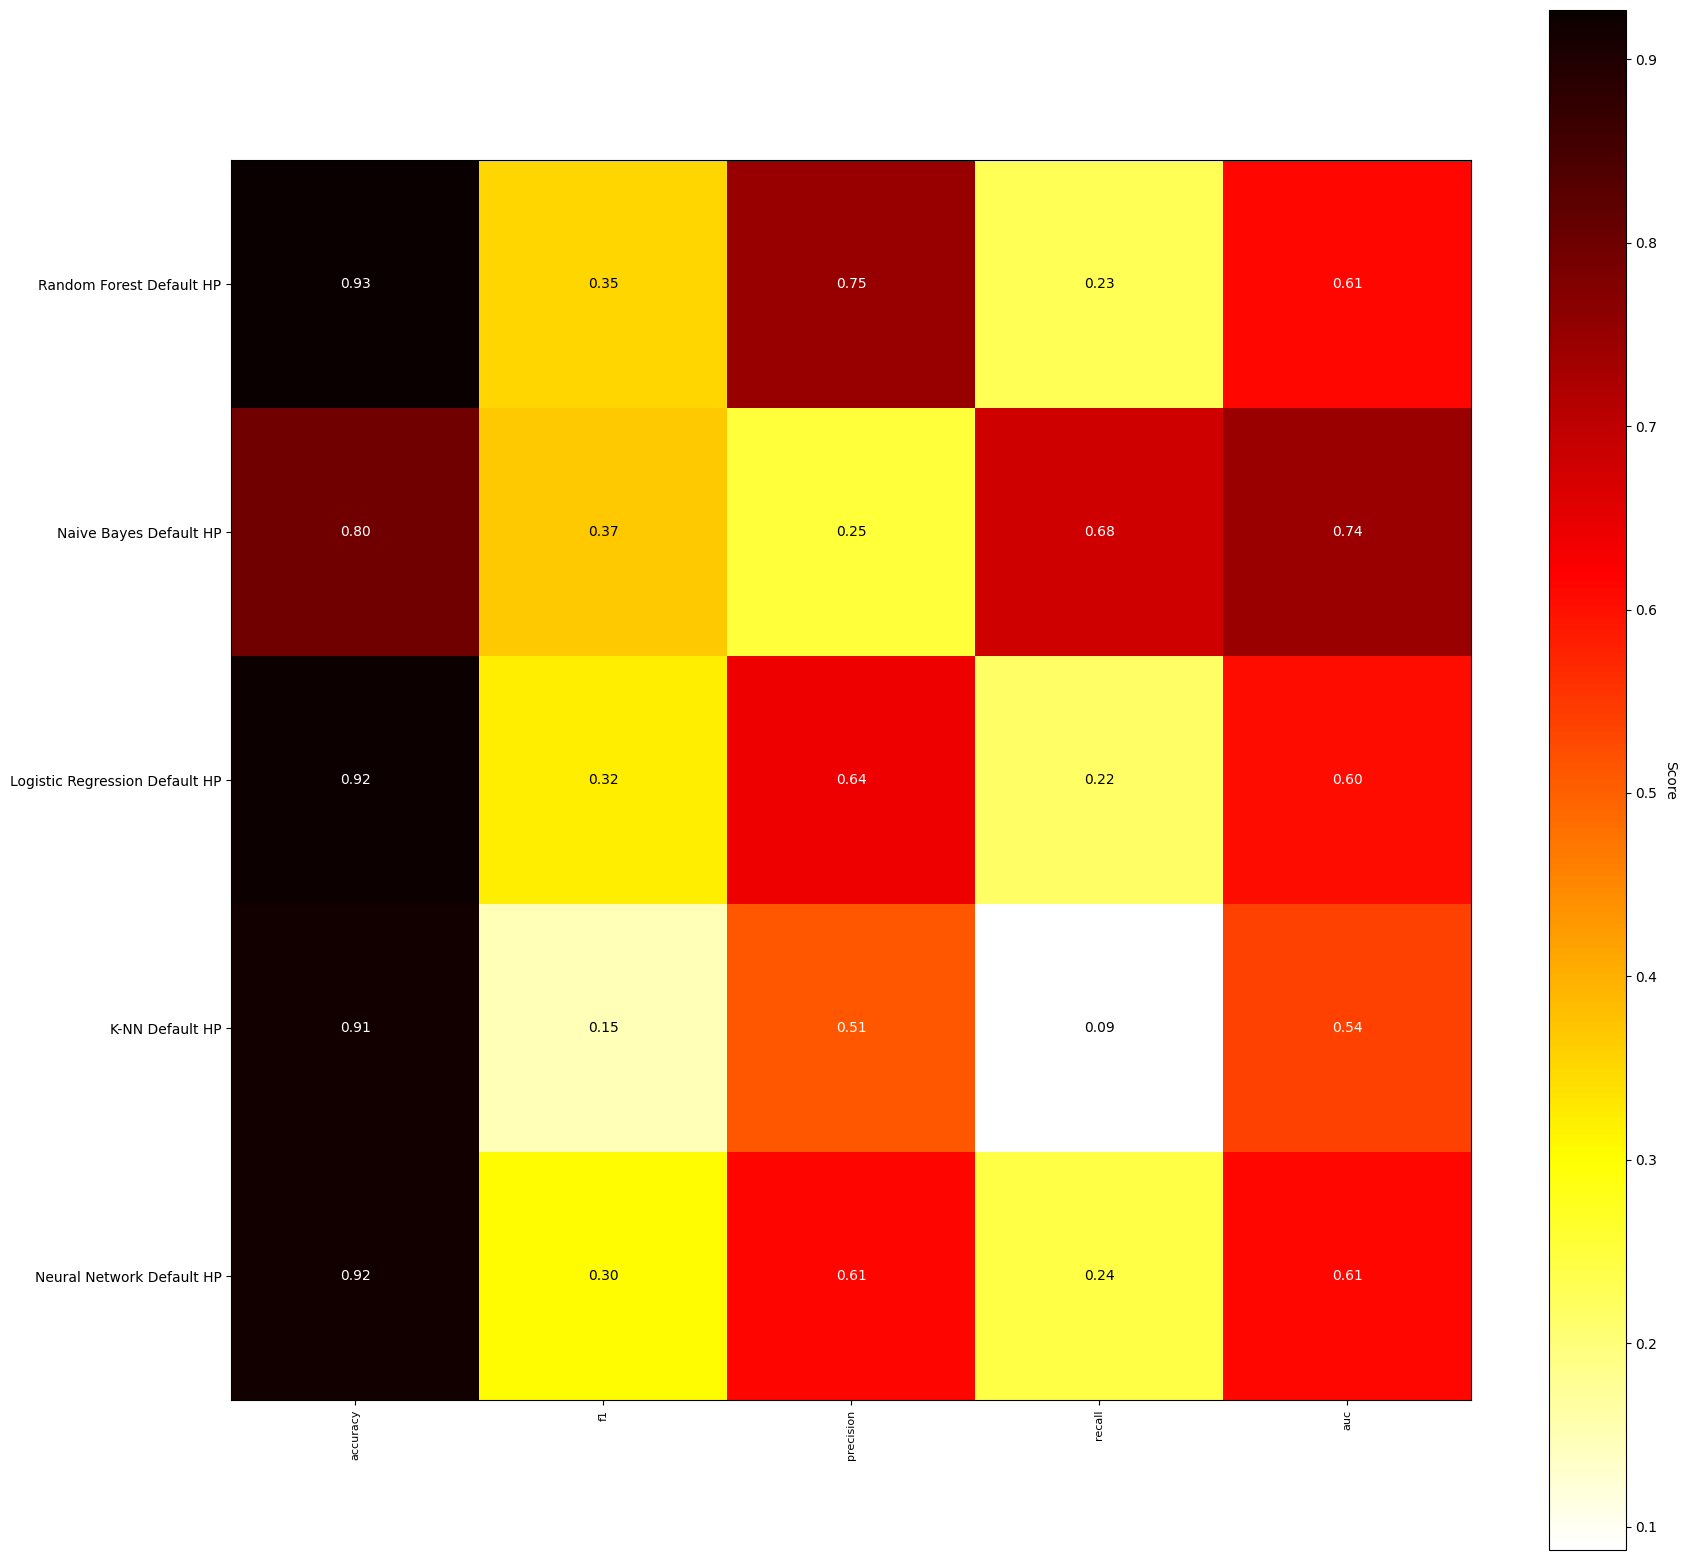

In [62]:
plot_heatmap(aggregated_results=aggregated_results)

We can see that accuracy is pretty high in all models, whereas other measures fall behind<br>
NB is the only one that does pretty well in recall but it preforms poorly in precision where others are better

We will suggest the same models with different hyper parameters to try and increase the measures 

In [26]:
# here comes the ugliest part of the code .......

# TODO: use a HP metrics

models_v2 = {
    "Random Forest (500/gini/10)": RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10, random_state=42),
    "Random Forest (250/gini/5)": RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=5, random_state=42),
    "Random Forest (1000/gini/3)": RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=3, random_state=42),
    "Random Forest (500/gini/3)": RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=3, random_state=42),
    "Random Forest (250/gini/10)": RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=10, random_state=42),
    "Random Forest (1000/gini/5)": RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5, random_state=42),
    "Random Forest (500/gini/5)": RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=5, random_state=42),
    "Random Forest (250/gini/10)": RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=10, random_state=42),    
    "Random Forest (500/entropy/10)": RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=10, random_state=42),
    "Random Forest (250/entropy/5)": RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=5, random_state=42),
    "Random Forest (1000/entropy/3)": RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=3, random_state=42),
    "Random Forest (500/entropy/3)": RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=3, random_state=42),
    "Random Forest (250/entropy/10)": RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=10, random_state=42),
    "Random Forest (1000/entropy/5)": RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=5, random_state=42),
    "Random Forest (500/entropy/5)": RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=5, random_state=42),
    "Random Forest (250/entropy/10)": RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=10, random_state=42),    
    # "Naive Bayes Default HP": GaussianNB(), not too many HP to play with
    "Logistic Regression (liblinear)": LogisticRegression(random_state=42, solver='liblinear'),
    "Logistic Regression (newton-cg)": LogisticRegression(random_state=42, solver='newton-cg'),
    "Logistic Regression (newton-cholesky)": LogisticRegression(random_state=42, solver='newton-cholesky'),
    "Logistic Regression (sag)": LogisticRegression(random_state=42, solver='sag'),
    "Logistic Regression (saga)": LogisticRegression(random_state=42, solver='saga'),
    "Logistic Regression (lbfgs)": LogisticRegression(random_state=42, solver='lbfgs'),
    "K-NN (10/manhattan)": KNeighborsClassifier(n_neighbors=10, metric='manhattan'),
    "K-NN (10/nan_euclidean)": KNeighborsClassifier(n_neighbors=10, metric='nan_euclidean'),
    "K-NN (10/euclidean)": KNeighborsClassifier(n_neighbors=10, metric='euclidean'),
    "K-NN (15/manhattan)": KNeighborsClassifier(n_neighbors=15, metric='manhattan'),
    "K-NN (15/nan_euclidean)": KNeighborsClassifier(n_neighbors=15, metric='nan_euclidean'),
    "K-NN (15/euclidean)": KNeighborsClassifier(n_neighbors=15, metric='euclidean'),
    "Neural Network (relu/adam/adaptive/20,30)": MLPClassifier(activation='relu', solver='adam', learning_rate='adaptive', hidden_layer_sizes=(20,30), random_state=42),
    "Neural Network (logistic/adam/adaptive/20,30)": MLPClassifier(activation='logistic', solver='adam', learning_rate='adaptive', hidden_layer_sizes=(20,30), random_state=42),
    "Neural Network (relu/adam/constant/20,30)": MLPClassifier(activation='relu', solver='adam', learning_rate='constant', hidden_layer_sizes=(20,30), random_state=42),
    "Neural Network (logistic/adam/constant/50,50)": MLPClassifier(activation='logistic', solver='adam', learning_rate='constant', hidden_layer_sizes=(50, 50), random_state=42),
    "Neural Network (relu/lbfgs/adaptive/50,50)": MLPClassifier(activation='relu', solver='lbfgs', learning_rate='adaptive', hidden_layer_sizes=(50, 50), random_state=42),
    "Neural Network (logistic/lbfgs/adaptive/50,50)": MLPClassifier(activation='logistic', solver='lbfgs', learning_rate='adaptive', hidden_layer_sizes=(50, 50), random_state=42),
    "Neural Network (relu/lbfgs/constant/50,50)": MLPClassifier(activation='relu', solver='lbfgs', learning_rate='constant', hidden_layer_sizes=(50, 50), random_state=42),
    "Neural Network (logistic/lbfgs/constant/20,30)": MLPClassifier(activation='logistic', solver='lbfgs', learning_rate='constant', hidden_layer_sizes=(20,30), random_state=42)
}


In [ ]:
# do the training
aggregated_results_v2 = train_and_evaluate_models(models=models_v2)
aggregated_results_v2

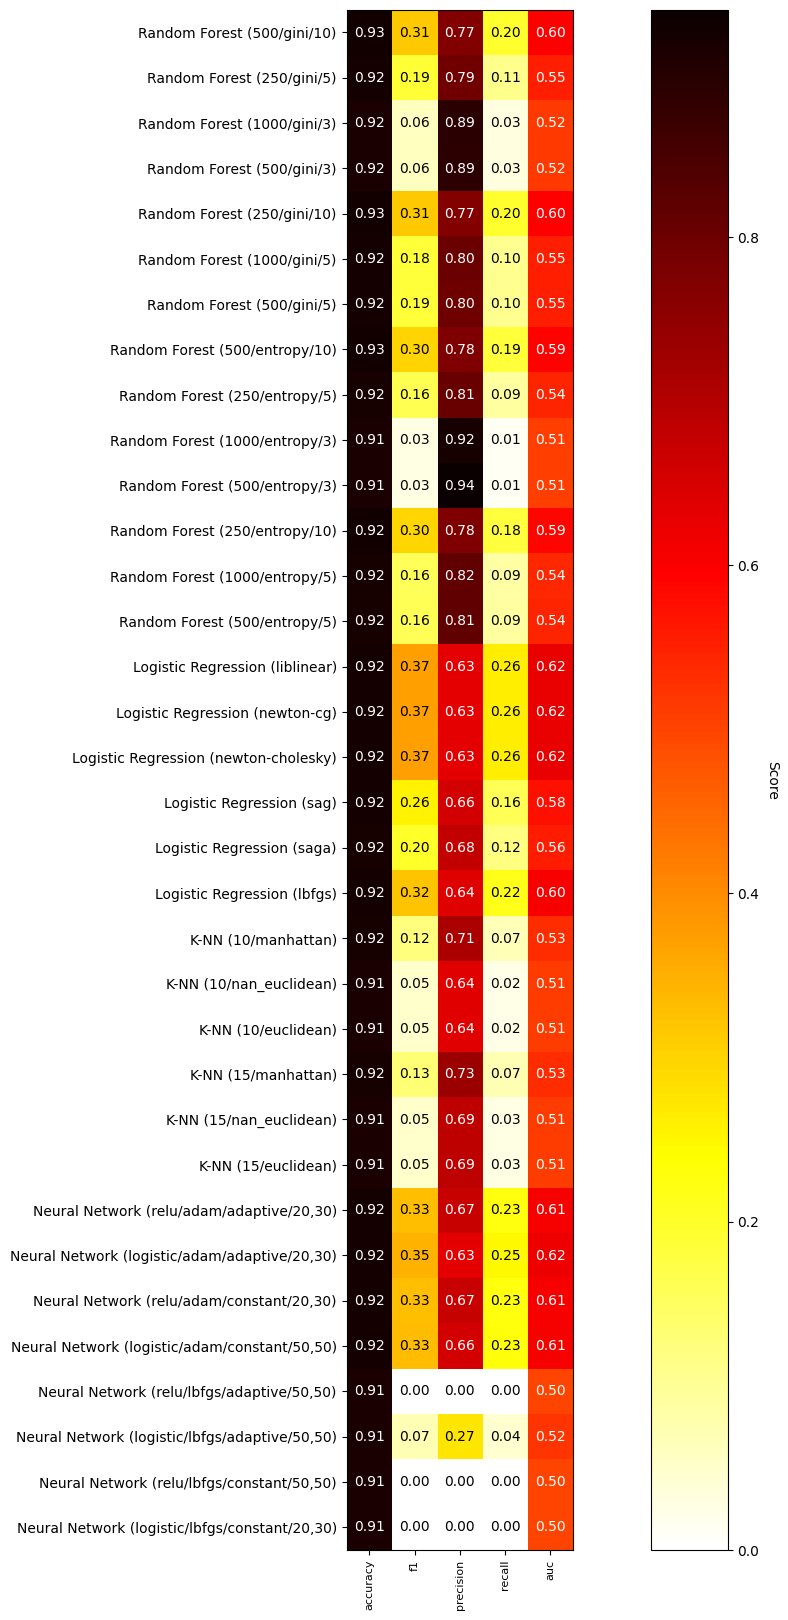

In [ ]:
plot_heatmap(aggregated_results=aggregated_results_v2)

<h3> The current scores are not good enought for production - level needs,<br> but satisfy for the choosing a model step

<h1>Decide on production models

In [29]:
chosen_models = [("RandomForest", models_v2["Random Forest (250/gini/10)"])
                ,("NeuralNetwork", models_v2["Neural Network (relu/adam/adaptive/20,30)"])
                ,("NaiveBayes", models["Naive Bayes Default HP"])]
chosen_models


[('RandomForest',
  RandomForestClassifier(max_depth=10, n_estimators=250, random_state=42)),
 ('NeuralNetwork',
  MLPClassifier(hidden_layer_sizes=(20, 30), learning_rate='adaptive',
                random_state=42)),
 ('NaiveBayes', GaussianNB())]

<h3>Generate ROC curve and confusion matrix for the chosen models

In [30]:
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

roc_train, roc_test = train_test_split(patients_df, test_size=0.3)


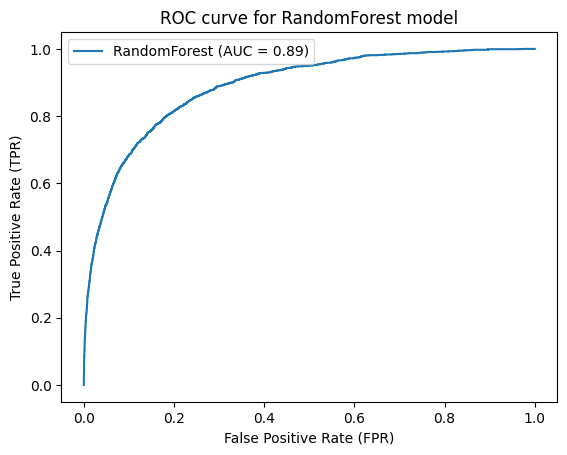

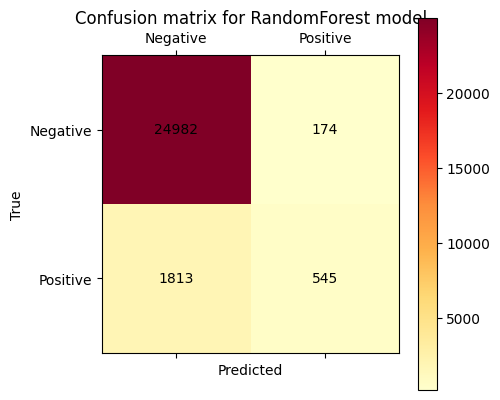

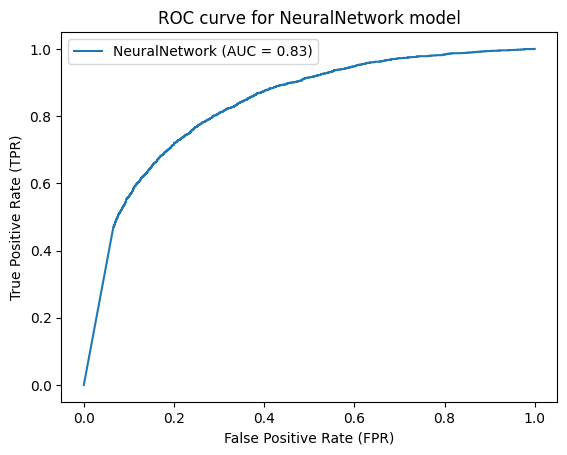

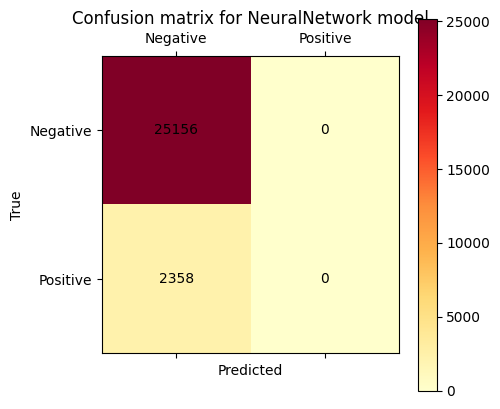

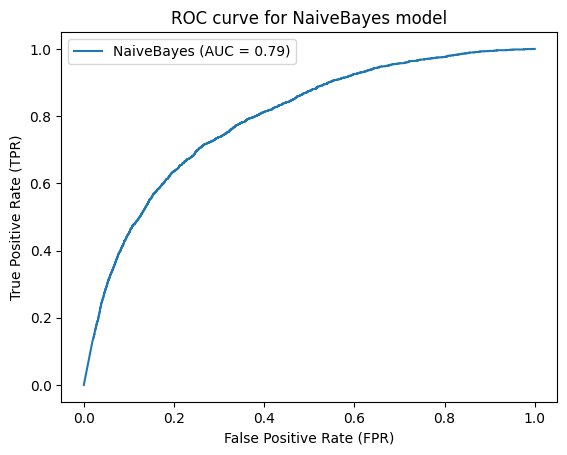

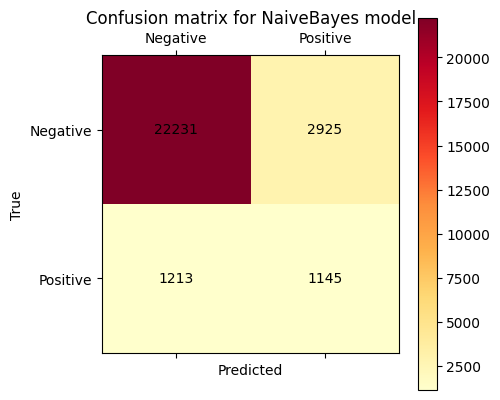

In [35]:
for model_name, model in chosen_models:
    # Fit the model on the training data
    model.fit(roc_train.drop(target, axis=1), roc_train[target])

    # Generate predictions on the test data
    y_pred = model.predict_proba(roc_test.drop(target, axis=1))[:, 1]
    y_true = roc_test[target]

    # Calculate the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC curve for {model_name} model')
    plt.legend()
    plt.show()

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred.round())
    plt.matshow(cm, cmap=plt.cm.YlOrRd)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion matrix for {model_name} model')
    plt.xticks([0,1], ['Negative', 'Positive'])
    plt.yticks([0,1], ['Negative', 'Positive'])
    for i in range(2):
        for j in range(2):
            plt.text(i, j, str(cm[j,i]), ha='center', va='center')
    plt.show()

In [36]:
@timeit
def production_train_and_generate_prediction(model_name, model, df_dict, patients_df_no_target, patients_df_target):    
    model.fit(patients_df_no_target, patients_df_target)  
    print(patients_df_no_target.columns)
    print(unlabeled.columns)
    unlabeled_prediction = model.predict(unlabeled[[x for x in patients_df.columns if x != target]])
    unlabeled_prediction_prob = model.predict_proba(unlabeled[[x for x in patients_df.columns if x != target]])[:, 1]
    print(unlabeled_prediction)
    print(unlabeled_prediction_prob) 
    df = pd.DataFrame(columns=[main_id_col_name, target])   
    df[target] = np.where(unlabeled_prediction == 1, 0.5 + unlabeled_prediction_prob / 2, 0 + unlabeled_prediction_prob / 2)
    # df[target] = unlabeled_prediction
    df[main_id_col_name] = main_id_col
    # unlabeled[[main_id_col, target]].to_csv(f'./data/{model_name}Prediction.csv')
    print(df.head(5))
    df_dict[model_name] = df


In [37]:
patients_df_no_target = patients_df.drop(columns=[target])
patients_df_target = patients_df[target]    

# perform_binning(train_df=patients_df, test_df=unlabeled, features_to_bin=features_to_bin)

df_dict_to_save = {}

for model_name, model in chosen_models:
    production_train_and_generate_prediction(model_name=model_name, model=model, df_dict=df_dict_to_save, patients_df_no_target=patients_df_no_target, patients_df_target=patients_df_target)

Index(['age', 'bmi', 'elective_surgery', 'height', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'weight',
       'albumin_apache',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=167)
Index(['age', 'bmi', 'elective_surgery', 'height', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'weight',
       'albumin_apache',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=167)
[0 0 0 ... 0 0 0]
[0.06155228 0.02899714 0.0482155  ... 0.09458779 0.03892491 0.09

In [38]:
for n, df in df_dict_to_save.items():
    df.to_csv(f'./data/{n}Pred.csv', index=False)

<h3>We tried doing the same but training the models 3 times on the same dataset

<h4>In the following image: <ul>
<li>Middle 3: 3 retrains (best results)</li>
<li>Top 3: 10 retrains</li>
<li>Bottom 3: 1 retrain(worst results)</li>

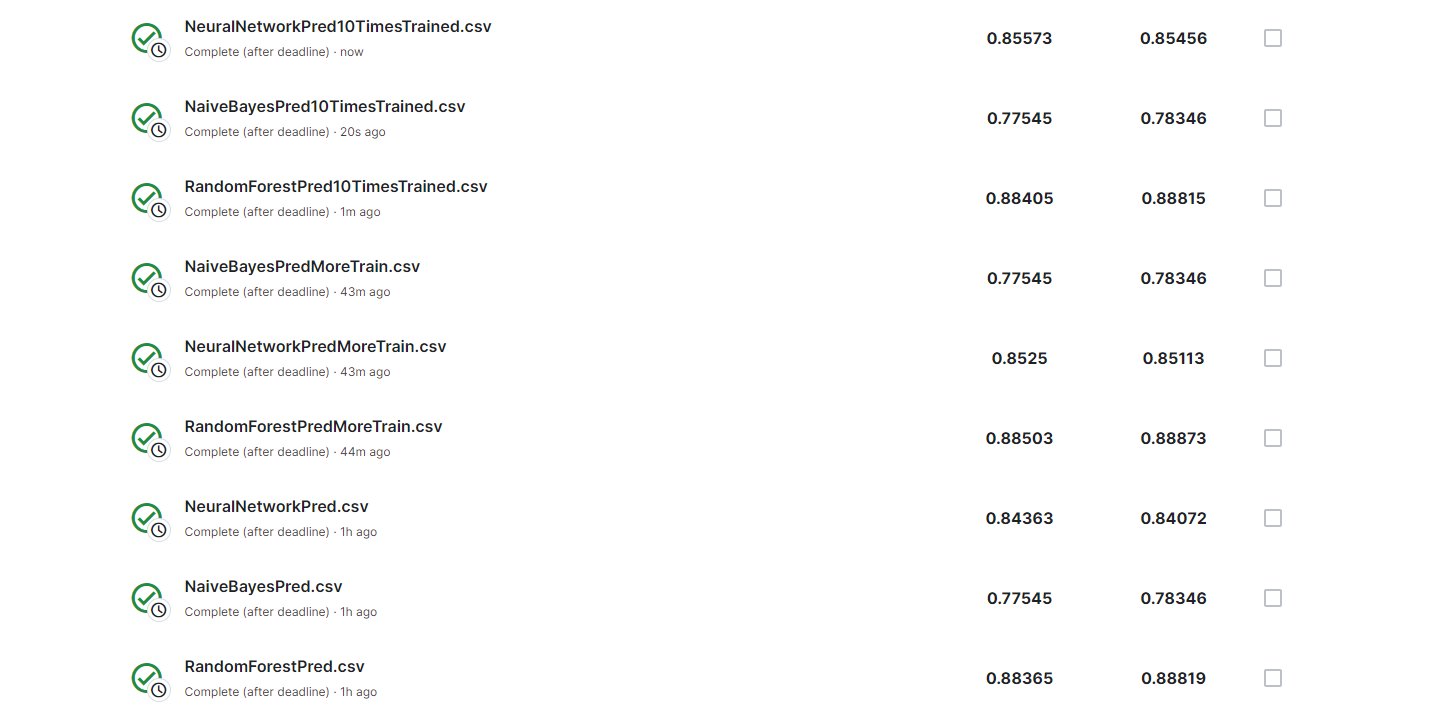

In [39]:
how_many_times_to_retrain = 3

patients_df_no_target_bigger = pd.concat([patients_df_no_target]*how_many_times_to_retrain)
patients_df_target_bigger = pd.concat([patients_df_target]*how_many_times_to_retrain)

df_dict_more_training = {}

for model_name, model in chosen_models:
    production_train_and_generate_prediction(model_name=model_name, model=model, df_dict=df_dict_more_training, patients_df_no_target=patients_df_no_target_bigger, patients_df_target=patients_df_target_bigger)

Index(['age', 'bmi', 'elective_surgery', 'height', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'weight',
       'albumin_apache',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=167)
Index(['age', 'bmi', 'elective_surgery', 'height', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'weight',
       'albumin_apache',
       ...
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'hospital_visit_count', 'hospital_death_count',
       'clustering_value'],
      dtype='object', length=167)
[0 0 0 ... 0 0 0]
[0.05626129 0.0241352  0.04253649 ... 0.09906567 0.0446013  0.09

In [40]:
for n, df in df_dict_more_training.items():
    df.to_csv(f'./data/{n}Pred{how_many_times_to_retrain}TimesTrained.csv', index=False)

<h3>Lets try to mix the results together

In [41]:
df_dict_more_training = {
    "RL": pd.read_csv('./data/RandomForestPredMoreTrain.csv'),
    "NB": pd.read_csv('./data/NaiveBayesPredMoreTrain.csv'),
    "ANN": pd.read_csv('./data/NeuralNetworkPredMoreTrain.csv')
}
main_id_col_name = 'encounter_id'
target='hospital_death'

Using the AUC scores from kaggle to aggregate into 1 model

Also tried:<br>
Taking into account that NB has a very high recall (from cross_val) and giving more weight to it if it has a lower than 0.4 prediction<br>
Using equal weights between all 3 models

In [42]:
aggregated_score_between_models = {}
for model, df_model in df_dict_more_training.items():
    for i, row in df_model.iterrows():
        if row[main_id_col_name] not in aggregated_score_between_models.keys():
            aggregated_score_between_models[row[main_id_col_name]] = {}
        aggregated_score_between_models[row[main_id_col_name]][model] = row[target]

for id, scores in aggregated_score_between_models.items():
    aggregated_score_between_models[id] = (scores['RL']*0.88873 + scores['ANN']*0.85113 + scores['NB']*0.78346) / \
                                                    (0.88873 + 0.85113 + 0.78346)

aggregated_score_between_models
aggregated_score_between_models_df = pd.DataFrame(data={main_id_col_name: [int(x) for x in aggregated_score_between_models.keys()],\
                                                        target: list(aggregated_score_between_models.values())})

aggregated_score_between_models_df.to_csv(f'./data/aggregated_prediction.csv', index=False)

<h3>This did not perform better than random forrest but did get a good score as well

Might be good for actual never unseen data - without trying to import unlabeled kaggle data specifically

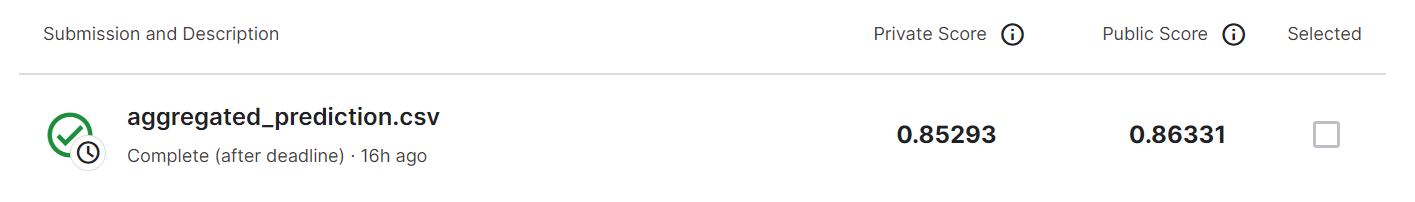